<a href="https://colab.research.google.com/github/hriteshMaikap/fromScratch/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree from Scratch

##1. Understanding and exploring the data
The dataset chosen is about `Plant Growth Data Classification` where based on factors like `soil-type`, `sunlight-hours`, `water-frequency`, `fertilizer-types`, `temperature`, `humidity` we need to predict the *growth milestone* (either 0 or 1). This is a simple binary classification task which is suitable for a decision tree being designed from scratch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/plant_growth_data.csv")

In [ ]:
df.head()

,Soil_Type,Sunlight_Hours,Water_Frequency,Fertilizer_Type,Temperature,Humidity,Growth_Milestone
0,loam,5.192294,bi-weekly,chemical,31.719602,61.591861,0
1,sandy,4.033133,weekly,organic,28.919484,52.422276,1
2,loam,8.892769,bi-weekly,none,23.179059,44.660539,0
3,loam,8.241144,bi-weekly,none,18.465886,46.433227,0
4,sandy,8.374043,bi-weekly,organic,18.128741,63.625923,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Soil_Type         193 non-null    object 
 1   Sunlight_Hours    193 non-null    float64
 2   Water_Frequency   193 non-null    object 
 3   Fertilizer_Type   193 non-null    object 
 4   Temperature       193 non-null    float64
 5   Humidity          193 non-null    float64
 6   Growth_Milestone  193 non-null    int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 10.7+ KB


In [ ]:
df.isna().sum()

,0
Soil_Type,0
Sunlight_Hours,0
Water_Frequency,0
Fertilizer_Type,0
Temperature,0
Humidity,0
Growth_Milestone,0


In [ ]:
for column in df.columns:
  if pd.api.types.is_object_dtype(df[column]):
    print(f"For the catgeorical column {column}, the unique values are:")
    print(df[column].unique(), "\n\n")

For the catgeorical column Soil_Type, the unique values are:
['loam' 'sandy' 'clay'] 


For the catgeorical column Water_Frequency, the unique values are:
['bi-weekly' 'weekly' 'daily'] 


For the catgeorical column Fertilizer_Type, the unique values are:
['chemical' 'organic' 'none'] 




###Distribution of Data (to check if data is equally split in categories)

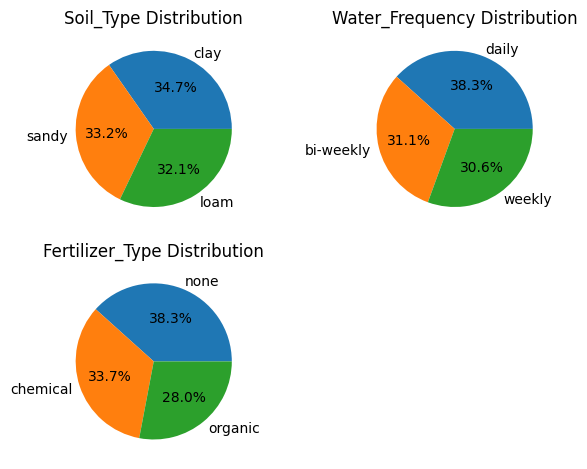

In [ ]:
cat_cols = [column for column in df.columns if pd.api.types.is_object_dtype(df[column])]
n_cols = 2
n_rows = (len(cat_cols)+1)//n_cols
fig, ax = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
ax = ax.flatten() #this prevents the error: 'numpy.ndarray' object has no attribute 'pie'
for i, column in enumerate(cat_cols):
  counts = df[column].value_counts()
  ax[i].pie(counts, labels=counts.index, autopct='%1.1f%%')
  ax[i].set_title(f'{column} Distribution')
# Hide any unused subplots
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])
plt.tight_layout()
plt.show()

###Checking if the data is balanced

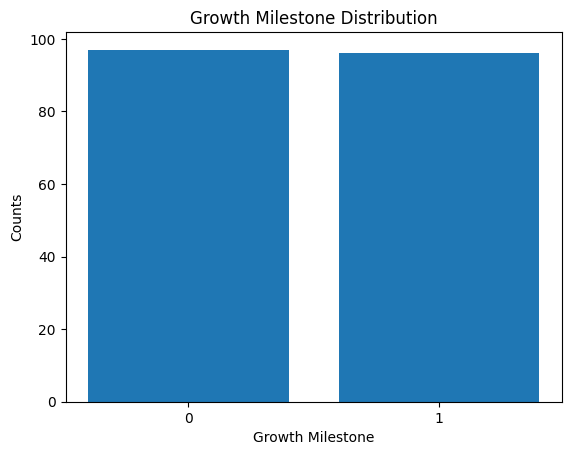

In [ ]:
growth_counts = df["Growth_Milestone"].value_counts()
plt.bar(growth_counts.index, growth_counts.values)
plt.xlabel('Growth Milestone')
plt.xticks([0,1])
plt.ylabel('Counts')
plt.title('Growth Milestone Distribution')
plt.show()

###Encoding the data

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])
  label_encoders[col] = le

### Data Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler
numerical_features = []
for val in df.columns:
  if pd.api.types.is_numeric_dtype(df[val]):
    numerical_features.append(val)
scaler = StandardScaler()
numerical_features.remove('Growth_Milestone')

df[numerical_features] = scaler.fit_transform(df[numerical_features])

###Correlation Matrix

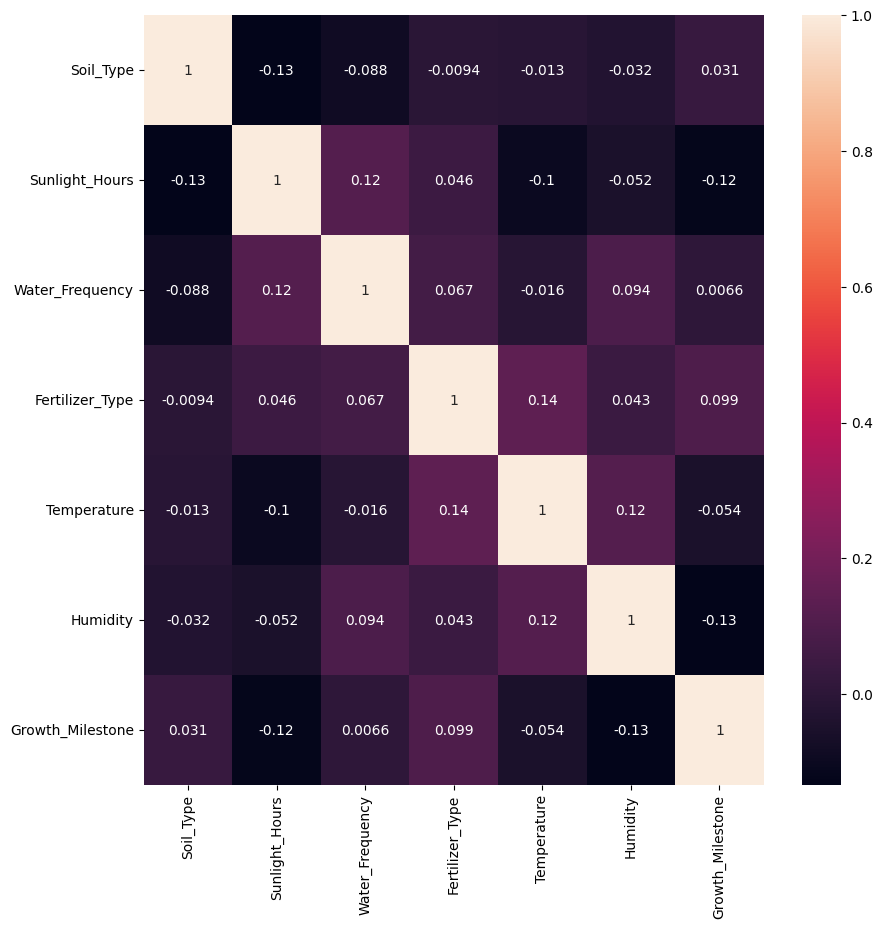

In [ ]:
import seaborn as sns
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)
plt.show()

##2. Preparing the dataset for custom Decision Tree Function

In [ ]:
X = df.drop("Growth_Milestone", axis=1).values
y = df["Growth_Milestone"].values.reshape(-1,1)

##3. Custom Classes and Methods

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
      """
    feature: feature used for splitting at this node. Default None
    threshold: The threshold used for splitting at this node
    left: The left child node.
    right: The right child node
    gain: The gain of the split
    value: If this node is a leaf node, this attribute represents the predicted value for target variable
    """
      self.feature = feature
      self.threshold = threshold
      self.left = left
      self.right = right
      self.gain = gain
      self.value = value

In [ ]:
class DecisionTree():
    """
    A decision tree classifier for binary classification problem
    """
    def __init__(self, min_samples=2, max_depth=2):
        """
        Constructor for decision tree class
        min_samples: Minimum number of samples required to split an internal node
        max_depth: Maximum depth of the decision tree
        """
        self.min_samples = min_samples
        self.max_depth = max_depth

    def split_data(self, dataset, feature, threshold):
        """
        Splits the dataset into two datasets based on the given feature and threshold
        Parameters:
        dataset (ndarray): input dataset
        feature (int): index of the feature on which the dataset is to be split
        threshold (float): Threshold value to split the feature on

        Returns:
        left_dataset (ndarray): Subset of the dataset with values less than or equal to the threshold
        right_dataset (ndarray): Subset of the dataset with values greater than the threshold
        """
        left_dataset = []
        right_dataset = []
        for row in dataset:
            if row[feature] <= threshold:
                left_dataset.append(row)
            else:
                right_dataset.append(row)

        left_dataset = np.array(left_dataset)
        right_dataset = np.array(right_dataset)
        return left_dataset, right_dataset

    def entropy(self, y):
        """
        Computes the entropy of the given label values
        Parameters:
        y (ndarray): Input label values.

        Returns:
        entropy (float): Entropy of the given label values.
        """
        entropy = 0
        labels = np.unique(y)
        for label in labels:
            # Find examples in y that have the current label
            label_examples = y[y == label]
            # Calculate the ratio of the current label
            p1 = len(label_examples) / len(y)
            entropy += -p1 * np.log2(p1)

        return entropy

    def information_gain(self, parent, left, right):
        """
        Parameters:
        parent (ndarray): Input parent dataset
        left (ndarray): Subset of the parent dataset after splitting it on a feature
        right (ndarray): Subset of the parent dataset after splitting it on a feature

        Returns:
        information_gain (float)
        """
        parent_entropy = self.entropy(parent)
        weight_left = len(left) / len(parent)
        weight_right = len(right) / len(parent)
        entropy_left, entropy_right = self.entropy(left), self.entropy(right)
        weighted_entropy = weight_left * entropy_left + weight_right * entropy_right
        information_gain = parent_entropy - weighted_entropy

        return information_gain

    def best_split(self, dataset, num_samples, num_features):
        """
        Finds the best split for the dataset
        Parameters:
        dataset (ndarray): The dataset to split
        num_samples (int): The number of samples in the dataset
        num_features (int): The number of features in the dataset

        Returns:
        dict: A dictionary with the best split feature index, threshold, gain, left and right datasets
        """
        best_split = {'gain': -1, 'feature': None, 'threshold': None}
        for feature_index in range(num_features):
            # Get the feature at the current feature_index
            feature_values = dataset[:, feature_index]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                left_dataset, right_dataset = self.split_data(dataset, feature_index, threshold)
                if len(left_dataset) and len(right_dataset):
                    y, left_y, right_y = dataset[:, -1], left_dataset[:, -1], right_dataset[:, -1]
                    information_gain = self.information_gain(y, left_y, right_y)
                    if information_gain > best_split["gain"]:
                        best_split["feature"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["left_dataset"] = left_dataset
                        best_split["right_dataset"] = right_dataset
                        best_split["gain"] = information_gain

        return best_split

    def calculate_leaf_value(self, y):
        y = list(y)
        most_occurring_value = max(y, key=y.count)
        return most_occurring_value

    def build_tree(self, dataset, current_depth=0):
        """
        Recursively build a decision tree from the given dataset
        Parameters:
        dataset (ndarray): The dataset to build the tree from.
        current_depth (int): The current depth of the tree

        Returns:
        Node: The node of the built decision tree
        """
        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape
        if n_samples >= self.min_samples and current_depth <= self.max_depth:
            best_split = self.best_split(dataset, n_samples, n_features)
            # Checks if the gain isn't zero
            if best_split["gain"]:
                left_node = self.build_tree(best_split["left_dataset"], current_depth + 1)
                right_node = self.build_tree(best_split["right_dataset"], current_depth + 1)
                return Node(best_split["feature"], best_split["threshold"], left_node, right_node, best_split["gain"])
        leaf_value = self.calculate_leaf_value(y)
        return Node(value=leaf_value)

    def make_prediction(self, x, node):
        """
        Traverse the decision tree to predict the target value for the given feature vector
        """
        # If the node is a leaf node/ it has value
        if node.value is not None:
            return node.value
        else:
            feature = x[node.feature]
            if feature <= node.threshold:
                return self.make_prediction(x, node.left)
            else:
                return self.make_prediction(x, node.right)

    def fit(self, X, y):
        dataset = np.concatenate((X, y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        predictions = []
        for x in X:
            prediction = self.make_prediction(x, self.root)
            predictions.append(prediction)
        return np.array(predictions)

## 4. Evaluations

In [ ]:
def train_test_split(X, y, random_state=42, test_size=0.2):
    n_samples = X.shape[0]
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(np.arange(n_samples))
    test_size = int(n_samples * test_size)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

In [ ]:
def accuracy(y_true, y_pred):
  y_true = y_true.flatten()
  total_samples = len(y_true)
  correct_predictions = np.sum(y_true == y_pred)
  return (correct_predictions / total_samples)

## 5. Calling the model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
model = DecisionTree(2, 2)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f"Model's Accuracy: {accuracy(y_test, preds)}")

Model's Accuracy: 0.5263157894736842


# Using In-Built Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
X = df.drop('Growth_Milestone', axis=1)
y = df['Growth_Milestone']

In [ ]:
label_encoders = {}
for col in X.select_dtypes(include='object').columns:
  le = LabelEncoder()
  X[col] = le.fit_transform(X[col])
  label_encoders[col] = le

In [ ]:
numerical_features = ['Sunlight_Hours', 'Temperature', 'Humidity']
scaler = StandardScaler()

X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = DecisionTreeClassifier(random_state=42)

In [ ]:
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score is: {accuracy:.2f}")

Accuracy score is: 0.57
